In [2]:
# import files
!cp /content/drive/MyDrive/capstone/src/dataset.py .
!cp /content/drive/MyDrive/capstone/src/models.py .
!cp /content/drive/MyDrive/capstone/src/utils.py .
!cp /content/drive/MyDrive/capstone/src/metrics.py .
!cp /content/drive/MyDrive/capstone/src/losses.py .

In [70]:
from dataset import *
from models import Unet_Loc, UNet_Double
from utils import AverageMeter
from metrics import *
from os import path, makedirs, listdir
from sklearn.model_selection import train_test_split
from losses import *
import timeit
from torch.backends import cudnn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim import lr_scheduler
import torch.optim as optim
import torch
from torch import nn
from tqdm import tqdm
import gc
from PIL import Image, ImageDraw
import json
from IPython.display import display
from shapely import wkt
from shapely.geometry.multipolygon import MultiPolygon
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [4]:
train_dir = '/content/drive/MyDrive/capstone/data/split_data/'

In [9]:
img_list = listdir('/content/drive/MyDrive/capstone/data/split_data/images')

In [13]:
mask_list = listdir('/content/drive/MyDrive/capstone/data/split_data/masks')

In [14]:
len(mask_list), len(img_list)

(89568, 89568)

In [15]:
def train_loc_model(model, data_loaders, optimizer, scheduler, seg_loss, num_epochs, weight_dir, snapshot_name, log_dir, best_score=0):
    '''
    Localization of buildings in the images
    '''
    writer = SummaryWriter(log_dir + 'localization')
    print('Tensorboard is recording into folder: ' + log_dir + 'localization')

    torch.cuda.empty_cache()

    for epoch in range(num_epochs):
        losses = AverageMeter()

        dices = AverageMeter()
        iterator = data_loaders['train']
        iterator = tqdm(iterator)
        model.train()
        for i, sample in enumerate(iterator):
            imgs = sample["img"].cuda(non_blocking=True)
            msks = sample["msk"].cuda(non_blocking=True)
        
            out = model(imgs)

            loss = seg_loss(out, msks)

            with torch.no_grad():
                _probs = torch.sigmoid(out[:, 0, ...])
                dice_sc = 1 - dice_round(_probs, msks[:, 0, ...])

            losses.update(loss.item(), imgs.size(0))

            dices.update(dice_sc, imgs.size(0))

            iterator.set_description("Epoch {}/{}, lr {:.7f}; Loss {loss.val:.4f} ({loss.avg:.4f}); Dice {dice.val:.4f} ({dice.avg:.4f})".format(
                    epoch, num_epochs, scheduler.get_lr()[-1], loss=losses, dice=dices))
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.999)
            optimizer.step()

            writer.add_scalar('Train/Loss', losses.avg, epoch)
            writer.add_scalar('Train/Dice', dice_sc, epoch)
            writer.flush()
        
        if epoch % 2 == 0:
            torch.cuda.empty_cache()

            model = model.eval()
            dices0 = []

            _thr = 0.5
            iterator = data_loaders['val']
            iterator = tqdm(iterator)
            with torch.no_grad():
                for i, sample in enumerate(iterator):
                    msks = sample["msk"].numpy()
                    imgs = sample["img"].cuda(non_blocking=True)
            
                    out = model(imgs)

                    msk_pred = torch.sigmoid(out[:, 0, ...]).cpu().numpy()
            
                    for j in range(msks.shape[0]):
                        dices0.append(dice(msks[j, 0], msk_pred[j] > _thr))

            d = np.mean(dices0)

            writer.add_scalar('Val/Dice', d, epoch)
            writer.flush()

            print("Val Dice: {}".format(d))

            if d > best_score:
                best_score = d
                torch.save({
                    'epoch': epoch + 1,
                    'state_dict': model.state_dict(),
                    'best_score': d,
                }, path.join(weight_dir, snapshot_name + '_best'))

            print("score: {}\tscore_best: {}".format(d, best_score))

        writer.close()
            
    return best_score

In [16]:
def train_cls_model(model, data_loaders, optimizer, scheduler, seg_loss, ce_loss, num_epochs, weight_dir, snapshot_name, log_dir, best_score=0):
    '''
    Identifying the level of building damage
    '''
    torch.cuda.empty_cache()

    writer = SummaryWriter(log_dir + 'classification')
    print('Tensorboard is recording into folder: ' + log_dir + 'classification')

    for epoch in range(num_epochs):
        losses = AverageMeter()
        dices = AverageMeter()
        
        iterator = data_loaders['train']
        iterator = tqdm(iterator)
        model.train()
        for i, sample in enumerate(iterator):
            imgs = sample["img"].cuda(non_blocking=True)
            msks = sample["msk"].cuda(non_blocking=True)
            lbl_msk = sample["lbl_msk"].cuda(non_blocking=True)
        
            out = model(imgs)

            loss_loc = seg_loss(out[:, 0, ...], msks[:, 0, ...])
            loss1 = seg_loss(out[:, 1, ...], msks[:, 1, ...])
            loss2 = seg_loss(out[:, 2, ...], msks[:, 2, ...])
            loss3 = seg_loss(out[:, 3, ...], msks[:, 3, ...])
            loss4 = seg_loss(out[:, 4, ...], msks[:, 4, ...])

            loss5 = ce_loss(out, lbl_msk)

            loss = 0.1 * loss_loc + 0.1 * loss1 + 0.3 * loss2 + 0.3 * loss3 + 0.2 * loss4 + loss5 * 11

            with torch.no_grad():
                _probs = torch.sigmoid(out[:, 0, ...])
                dice_sc = 1 - dice_round(_probs, msks[:, 0, ...])

            losses.update(loss.item(), imgs.size(0))

            dices.update(dice_sc, imgs.size(0))

            iterator.set_description("Epoch {}/{}, lr {:.7f}; Loss {loss.val:.4f} ({loss.avg:.4f}); Dice {dice.val:.4f} ({dice.avg:.4f})".format(
                    epoch, num_epochs, scheduler.get_lr()[-1], loss=losses, dice=dices))
        
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.999)
            optimizer.step()

            writer.add_scalar('Train/Loss', losses.avg, epoch)
            writer.add_scalar('Train/Dice', dice_sc, epoch)
            writer.add_scalar('Train/Loc_loss', loss_loc, epoch)
            writer.add_scalar('Train/NoDamage_loss', loss1, epoch)
            writer.add_scalar('Train/MinorDamage_loss', loss2, epoch)
            writer.add_scalar('Train/MajorDamage_loss', loss3, epoch)
            writer.add_scalar('Train/Destroyed_loss', loss4, epoch)
            writer.add_scalar('Train/Cls_loss', loss4, epoch)

            writer.flush()
        
        if epoch % 2 == 0:
            torch.cuda.empty_cache()

            model = model.eval()
            dices0 = []

            tp = np.zeros((4,))
            fp = np.zeros((4,))
            fn = np.zeros((4,))

            _thr = 0.3
            
            iterator = data_loaders['val']
            iterator = tqdm(iterator)
            with torch.no_grad():
                for i, sample in enumerate(iterator):
                    msks = sample["msk"].numpy()
                    lbl_msk = sample["lbl_msk"].numpy()
                    imgs = sample["img"].cuda(non_blocking=True)
                    out = model(imgs)
                    
                    msk_pred = torch.sigmoid(out[:, 0, ...]).cpu().numpy()
                    msk_damage_pred = torch.sigmoid(out).cpu().numpy()[:, 1:, ...]
            
                    for j in range(msks.shape[0]):
                        dices0.append(dice(msks[j, 0], msk_pred[j] > _thr))

                        targ = lbl_msk[j][msks[j, 0] > 0]
                        pred = msk_damage_pred[j].argmax(axis=0)
                        pred = pred * (msk_pred[j] > _thr)
                        pred = pred[msks[j, 0] > 0]
                        for c in range(4):
                            tp[c] += np.logical_and(pred == c, targ == c).sum()
                            fn[c] += np.logical_and(pred != c, targ == c).sum()
                            fp[c] += np.logical_and(pred == c, targ != c).sum()

            d0 = np.mean(dices0)
            f1_sc = np.zeros((4,))
            
            for c in range(4):
                f1_sc[c] = 2 * tp[c] / (2 * tp[c] + fp[c] + fn[c])

            f1 = 4 / np.sum(1.0 / (f1_sc + 1e-6))

            sc = 0.3 * d0 + 0.7 * f1
            print("Val Score: {}, Dice: {}, F1: {}, F1_no-damage: {}, F1_minor-damage: {}, F1_major-damage: {}, F1_destroyed: {}".format(
                sc, d0, f1, f1_sc[0], f1_sc[1], f1_sc[2], f1_sc[3]))

            writer.add_scalar('Val/Score', sc, epoch)
            writer.add_scalar('Val/Dice', d0, epoch)
            writer.add_scalar('Val/NoDamage_F1', f1, epoch)
            writer.add_scalar('Val/MinorDamage_F1', f1_sc[0], epoch)
            writer.add_scalar('Val/MajorDamage_F1', f1_sc[1], epoch)
            writer.add_scalar('Val/Destroyed_F1', f1_sc[2], epoch)
            writer.add_scalar('Val/Cls_F1', f1_sc[3], epoch)

            writer.flush()
            
            if sc > best_score:
                torch.save({
                    'epoch': epoch + 1,
                    'state_dict': model.state_dict(),
                    'best_score': sc,
                }, path.join(weight_dir, snapshot_name + '_best'))
                best_score = sc

            print("score: {}\tscore_best: {}".format(sc, best_score))
        
        writer.close()

    return best_score

In [17]:
def main_loc(train_dir, img_list):
    # train_dirs = ['/content/drive/MyDrive/capstone/data/split_data']
    weight_dir = 'weights'
    makedirs(weight_dir, exist_ok=True)
    snapshot_name = '_unet_loc'

    log_dir = 'logs/unet_base/'
    makedirs(log_dir, exist_ok=True)

    all_files = []
 
    for f in img_list:
        if '_pre_disaster' in f:
            all_files.append(path.join(train_dir, 'images', f))

    # print(len(all_files))
    # all_files = all_files[:200]
    
    cudnn.benchmark = True

    batch_size = 16
    val_batch_size = 8

    train_idxs, val_idxs = train_test_split(np.arange(len(all_files)), test_size=0.2, random_state=42)
    print('train: ', len(train_idxs), ' validation: ', len(val_idxs))

    steps_per_epoch = len(train_idxs) // batch_size
    validation_steps = len(val_idxs) // val_batch_size

    print('steps_per_epoch', steps_per_epoch, 'validation_steps', validation_steps)

    data_train = TrainDataLoc(train_idxs, all_files=all_files)
    val_train = ValDataLoc(val_idxs, all_files=all_files)

    train_data_loader = DataLoader(data_train, batch_size=batch_size, num_workers=4, shuffle=True, pin_memory=False, drop_last=True)
    val_data_loader = DataLoader(val_train, batch_size=val_batch_size, num_workers=4, shuffle=False, pin_memory=False)

    data_loaders = {
        'train': train_data_loader,
        'val': val_data_loader
    }

    num_epochs = 5

    model = Unet_Loc(bilinear=False).cuda()
    
    model = nn.DataParallel(model).cuda()

    seg_loss = ComboLoss({'dice': 1.0, 'focal': 10.0}, per_image=False).cuda()

    optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

    scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=6, gamma=0.1)
    
    try:
        snap_to_load = '_unet_loc_best'
        print("=> loading checkpoint '{}'".format(snap_to_load))
        checkpoint = torch.load(path.join(weight_dir, snap_to_load), map_location='cpu')
        loaded_dict = checkpoint['state_dict']
        state_dict = model.state_dict()
        for k in state_dict:
            if k in loaded_dict and state_dict[k].size() == loaded_dict[k].size():
                state_dict[k] = loaded_dict[k]
        # loaded_dict = sd
        model.load_state_dict(state_dict)
        print("loaded checkpoint '{}' (epoch {}, best_score {})"
                .format(snap_to_load, checkpoint['epoch'], checkpoint['best_score']))
        best_score = checkpoint['best_score']
        del loaded_dict
        del state_dict
        del checkpoint
        gc.collect()
        torch.cuda.empty_cache()
    except:
        best_score = 0

    history = train_loc_model(model=model, data_loaders=data_loaders, optimizer=optimizer_ft, scheduler=scheduler, seg_loss=seg_loss, num_epochs=num_epochs, weight_dir=weight_dir, snapshot_name=snapshot_name, log_dir=log_dir, best_score=best_score)

    return history

In [18]:
def main_cls(train_dir, img_list, mask_list):
    # train_dirs = ['/content/drive/MyDrive/capstone/data/split_data']
    weight_dir = 'weights'
    makedirs(weight_dir, exist_ok=True)
    snapshot_name = '_unet_cls'
    
    log_dir = 'logs/unet_base/'
    makedirs(log_dir, exist_ok=True)

    all_files = []
    for f in img_list:
        if '_pre_disaster' in f:
            all_files.append(path.join(train_dir, 'images', f))

    # print(len(all_files))

    file_classes = []
    for fn in all_files:
        fl = np.zeros((4,), dtype=bool)
        msk1 = cv2.imread(fn.replace('/images/', '/masks/').replace('_pre_disaster', '_post_disaster'), cv2.IMREAD_UNCHANGED)
        for c in range(1, 5):
            fl[c-1] = c in msk1
        file_classes.append(fl)
    file_classes = np.asarray(file_classes)

    cudnn.benchmark = True

    batch_size = 8
    val_batch_size = 4

    train_idxs0, val_idxs = train_test_split(np.arange(len(all_files)), test_size=0.2, random_state=42)
    print('train: ', len(train_idxs0), ' validation: ', len(val_idxs))

    train_idxs = []
    for i in train_idxs0:
        train_idxs.append(i)
        if file_classes[i, 1:].max():
            train_idxs.append(i)
        if file_classes[i, 1:3].max():
                train_idxs.append(i)
    train_idxs = np.asarray(train_idxs)

    steps_per_epoch = len(train_idxs) // batch_size
    validation_steps = len(val_idxs) // val_batch_size

    print('steps_per_epoch', steps_per_epoch, 'validation_steps', validation_steps)

    data_train = TrainDataCls(train_idxs, all_files)
    val_train = ValDataCls(val_idxs, all_files)

    train_data_loader = DataLoader(data_train, batch_size=batch_size, num_workers=6, shuffle=True, pin_memory=False, drop_last=True)
    val_data_loader = DataLoader(val_train, batch_size=val_batch_size, num_workers=6, shuffle=False, pin_memory=False)

    data_loaders = {
        'train': train_data_loader,
        'val': val_data_loader
    }

    num_epochs = 5

    model = UNet_Double(bilinear=False).cuda()
    
    model = nn.DataParallel(model).cuda()

    seg_loss = ComboLoss({'dice': 1.0, 'focal': 12.0}, per_image=False).cuda()
    ce_loss = nn.CrossEntropyLoss().cuda()

    optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

    scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=6, gamma=0.1)
    
    try:
        snap_to_load = '_unet_cls_best'
        print("=> loading checkpoint '{}'".format(snap_to_load))
        checkpoint = torch.load(path.join(weight_dir, snap_to_load), map_location='cpu')
        loaded_dict = checkpoint['state_dict']
        state_dict = model.state_dict()
        for k in state_dict:
            if k in loaded_dict and state_dict[k].size() == loaded_dict[k].size():
                state_dict[k] = loaded_dict[k]
        # loaded_dict = sd
        model.load_state_dict(state_dict)
        print("loaded checkpoint '{}' (epoch {}, best_score {})"
                .format(snap_to_load, checkpoint['epoch'], checkpoint['best_score']))
        best_score = checkpoint['best_score']
        del loaded_dict
        del state_dict
        del checkpoint
        gc.collect()
        torch.cuda.empty_cache()
    except:    
        # Load pretrained with localization
        snap_to_load = '_unet_loc_best'
        print("=> loading checkpoint '{}'".format(snap_to_load))
        checkpoint = torch.load(path.join(weight_dir, snap_to_load), map_location='cpu')
        loaded_dict = checkpoint['state_dict']
        state_dict = model.state_dict()
        for k in state_dict:
            if k in loaded_dict and state_dict[k].size() == loaded_dict[k].size():
                state_dict[k] = loaded_dict[k]
        # loaded_dict = sd
        model.load_state_dict(state_dict)
        print("loaded checkpoint '{}' (epoch {}, best_score {})"
                .format(snap_to_load, checkpoint['epoch'], checkpoint['best_score']))
        best_score = 0
        del loaded_dict
        del state_dict
        del checkpoint
        gc.collect()
        torch.cuda.empty_cache()

    history = train_cls_model(model=model, data_loaders=data_loaders, optimizer=optimizer_ft, scheduler=scheduler, seg_loss=seg_loss, ce_loss=ce_loss, num_epochs=num_epochs, weight_dir=weight_dir, snapshot_name=snapshot_name, log_dir=log_dir, best_score=best_score)




In [20]:
history = main_loc(train_dir, img_list)

train:  35827  validation:  8957
steps_per_epoch 2239 validation_steps 1119
=> loading checkpoint '_unet_loc_best'
Tensorboard is recording into folder: logs/unet_base/localization


  0%|          | 0/2239 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:372: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
Epoch 0/5, lr 0.0001000; Loss 0.7776 (0.9866); Dice 0.5554 (0.3660): 100%|██████████| 2239/2239 [1:18:50<00:00,  2.11s/it]
100%|██████████| 1120/1120 [15:37<00:00,  1.20it/s]


Val Dice: 0.7542961656818253
score: 0.7542961656818253	score_best: 0.7542961656818253


Epoch 1/5, lr 0.0001000; Loss 0.5927 (0.7462); Dice 0.6727 (0.5629): 100%|██████████| 2239/2239 [17:09<00:00,  2.17it/s]
Epoch 2/5, lr 0.0001000; Loss 0.5204 (0.6854); Dice 0.6949 (0.6170): 100%|██████████| 2239/2239 [17:09<00:00,  2.18it/s]
100%|██████████| 1120/1120 [01:48<00:00, 10.30it/s]


Val Dice: 0.82330286404937
score: 0.82330286404937	score_best: 0.82330286404937


Epoch 3/5, lr 0.0001000; Loss 0.6080 (0.6367); Dice 0.6767 (0.6430): 100%|██████████| 2239/2239 [17:09<00:00,  2.17it/s]
Epoch 4/5, lr 0.0001000; Loss 0.4635 (0.6159); Dice 0.7028 (0.6584): 100%|██████████| 2239/2239 [17:09<00:00,  2.17it/s]
100%|██████████| 1120/1120 [01:49<00:00, 10.26it/s]


Val Dice: 0.836110556840183
score: 0.836110556840183	score_best: 0.836110556840183


In [22]:
def predict_loc():
    test_dir = '/content/drive/MyDrive/capstone/data/test/images'
    pred_loc_folder = '/content/drive/MyDrive/capstone/data/test/predict/pred-unet_loc'
    models_folder = 'weights'

    makedirs(pred_loc_folder, exist_ok=True)

    snap_to_load = '_unet_loc_best'

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = Unet_Loc(bilinear=False).to(device)
    model = nn.DataParallel(model).to(device)

    print("=> loading checkpoint '{}'".format(snap_to_load))
    checkpoint = torch.load(path.join(models_folder, snap_to_load), map_location='cpu')
    loaded_dict = checkpoint['state_dict']
    sd = model.state_dict()
    for k in model.state_dict():
        if k in loaded_dict and sd[k].size() == loaded_dict[k].size():
            sd[k] = loaded_dict[k]
    loaded_dict = sd
    model.load_state_dict(loaded_dict)
    print("loaded checkpoint '{}' (epoch {}, best_score {})"
            .format(snap_to_load, checkpoint['epoch'], checkpoint['best_score']))
    model.eval()  

    with torch.no_grad():
        for f in tqdm(sorted(listdir(test_dir))):
            if '_pre_' in f:
                fn = path.join(test_dir, f)

                image = cv2.imread(fn, cv2.IMREAD_COLOR)
                splitted_imgs = split_image(img=image)

                splitted_msks = []
                for img in splitted_imgs:
                    img = preprocess_inputs(img)

                    inp = []
                    inp.append(img)
                    inp.append(img[::-1, ...])
                    inp.append(img[:, ::-1, ...])
                    inp.append(img[::-1, ::-1, ...])
                    inp = np.asarray(inp, dtype='float')
                    inp = torch.from_numpy(inp.transpose((0, 3, 1, 2))).float()
                    inp = Variable(inp).to(device)

                    pred = []             
                    msk = model(inp)
                    msk = torch.sigmoid(msk)
                    msk = msk.cpu().numpy()

                    pred.append(msk[0, ...])
                    pred.append(msk[1, :, ::-1, :])
                    pred.append(msk[2, :, :, ::-1])
                    pred.append(msk[3, :, ::-1, ::-1])

                    pred_full = np.asarray(pred).mean(axis=0)
                    
                    msk = pred_full * 255
                    msk = msk.astype('uint8').transpose(1, 2, 0)

                    splitted_msks.append(msk)

                mask = merge_image(splitted_imgs=splitted_msks)
                cv2.imwrite(path.join(pred_loc_folder, f.replace('.png', '_part1.png')), mask[..., 0], [cv2.IMWRITE_PNG_COMPRESSION, 9])


In [23]:
predict_loc()

=> loading checkpoint '_unet_loc_best'
loaded checkpoint '_unet_loc_best' (epoch 5, best_score 0.836110556840183)


100%|██████████| 1886/1886 [34:06<00:00,  1.09s/it]


In [24]:
history2 = main_cls(train_dir, img_list, mask_list)

train:  35827  validation:  8957
steps_per_epoch 6152 validation_steps 2239


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


=> loading checkpoint '_unet_cls_best'
=> loading checkpoint '_unet_loc_best'
loaded checkpoint '_unet_loc_best' (epoch 5, best_score 0.836110556840183)
Tensorboard is recording into folder: logs/unet_base/classification


  0%|          | 0/6152 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:372: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
Epoch 0/5, lr 0.0001000; Loss 1.1570 (1.7912); Dice 0.6418 (0.4368): 100%|██████████| 6152/6152 [55:23<00:00,  1.85it/s]
100%|██████████| 2240/2240 [07:00<00:00,  5.33it/s]


Val Score: 0.3200909894029174, Dice: 0.6100462640252924, F1: 0.1958244431361853, F1_no-damage: 0.8619923194905049, F1_minor-damage: 0.06433330571959431, F1_major-damage: 0.42541165878535386, F1_destroyed: 0.7289192853744272
score: 0.3200909894029174	score_best: 0.3200909894029174


Epoch 1/5, lr 0.0001000; Loss 1.0892 (1.1652); Dice 0.5185 (0.6279): 100%|██████████| 6152/6152 [55:25<00:00,  1.85it/s]
Epoch 2/5, lr 0.0001000; Loss 0.8520 (1.1098); Dice 0.7468 (0.6689): 100%|██████████| 6152/6152 [55:24<00:00,  1.85it/s]
100%|██████████| 2240/2240 [04:12<00:00,  8.89it/s]


Val Score: 0.5510500125068367, Dice: 0.648967448785453, F1: 0.5090853969588582, F1_no-damage: 0.8949309370004604, F1_minor-damage: 0.2719671134734191, F1_major-damage: 0.5807252475911802, F1_destroyed: 0.7457438891273913
score: 0.5510500125068367	score_best: 0.5510500125068367


Epoch 3/5, lr 0.0001000; Loss 0.8220 (1.0746); Dice 0.6229 (0.6859): 100%|██████████| 6152/6152 [55:25<00:00,  1.85it/s]
Epoch 4/5, lr 0.0001000; Loss 1.1586 (1.0480); Dice 0.7629 (0.6994): 100%|██████████| 6152/6152 [55:23<00:00,  1.85it/s]
100%|██████████| 2240/2240 [04:10<00:00,  8.95it/s]


Val Score: 0.6367771095606061, Dice: 0.7066901913052076, F1: 0.6068143602414912, F1_no-damage: 0.9175321584588102, F1_minor-damage: 0.3779207664764695, F1_major-damage: 0.6628708564941915, F1_destroyed: 0.7422322059861299
score: 0.6367771095606061	score_best: 0.6367771095606061


In [44]:
def predict_cls():
    test_dir = '/content/drive/MyDrive/capstone/data/test/images'
    pred_cls_folder = '/content/drive/MyDrive/capstone/data/test/predict/pred-unet_cls'
    models_folder = 'weights'

    makedirs(pred_cls_folder, exist_ok=True)

    snap_to_load = '_unet_cls_best'

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = UNet_Double(bilinear=False).to(device)
    model = nn.DataParallel(model).to(device)

    print("=> loading checkpoint '{}'".format(snap_to_load))
    checkpoint = torch.load(path.join(models_folder, snap_to_load), map_location='cpu')
    loaded_dict = checkpoint['state_dict']
    sd = model.state_dict()
    for k in model.state_dict():
        if k in loaded_dict and sd[k].size() == loaded_dict[k].size():
            sd[k] = loaded_dict[k]
    loaded_dict = sd
    model.load_state_dict(loaded_dict)
    print("loaded checkpoint '{}' (epoch {}, best_score {})"
            .format(snap_to_load, checkpoint['epoch'], checkpoint['best_score']))
    model.eval()   

    with torch.no_grad():
        for f in tqdm(sorted(listdir(test_dir))):
          try:
              if '_pre_' in f:
                  fn = path.join(test_dir, f)

                  img = cv2.imread(fn, cv2.IMREAD_COLOR)
                  img2 = cv2.imread(fn.replace('_pre_', '_post_'), cv2.IMREAD_COLOR)

                  image = np.concatenate([img, img2], axis=2)

                  splitted_imgs = split_image(img=image)

                  splitted_msks = []


                  for img in splitted_imgs:

                      img = preprocess_inputs(img)

                      inp = []
                      inp.append(img)
                      inp.append(img[::-1, ...])
                      inp.append(img[:, ::-1, ...])
                      inp.append(img[::-1, ::-1, ...])
                      inp = np.asarray(inp, dtype='float')
                      inp = torch.from_numpy(inp.transpose((0, 3, 1, 2))).float()
                      inp = Variable(inp).to(device)

                      pred = []
                      
                      msk = model(inp)
                      msk = torch.sigmoid(msk)
                      msk = msk.cpu().numpy()

                      pred.append(msk[0, ...])
                      pred.append(msk[1, :, ::-1, :])
                      pred.append(msk[2, :, :, ::-1])
                      pred.append(msk[3, :, ::-1, ::-1])

                      pred_full = np.asarray(pred).mean(axis=0)
                      
                      msk = pred_full * 255
                      msk = msk.astype('uint8').transpose(1, 2, 0)

                      splitted_msks.append(msk)

                  mask = merge_image(splitted_msks)

                  cv2.imwrite(path.join(pred_cls_folder, f.replace('.png', '_part1.png')), mask[..., :3], [cv2.IMWRITE_PNG_COMPRESSION, 9])
                  cv2.imwrite(path.join(pred_cls_folder, f.replace('.png', '_part2.png')), mask[..., 2:], [cv2.IMWRITE_PNG_COMPRESSION, 9])
          except:
            pass


In [45]:
predict_cls()

=> loading checkpoint '_unet_cls_best'
loaded checkpoint '_unet_cls_best' (epoch 5, best_score 0.6367771095606061)


100%|██████████| 1880/1880 [1:15:44<00:00,  2.42s/it]


In [49]:
# checking the images, true vs predicted
true_img = listdir('/content/drive/MyDrive/capstone/data/test/labels')
pred_img = listdir('/content/drive/MyDrive/capstone/data/test/predict/pred-unet_cls')

In [53]:
def read_label(label_path):
    with open(label_path) as json_file:
        image_json = json.load(json_file)
        return image_json

# Color codes for polygons of different damage levels
# rgba
damage_dict = {
    "no-damage": (0, 255, 0, 50),  # green
    "minor-damage": (0, 0, 255, 50),  # blue
    "major-damage": (255, 69, 0, 50),  # brownish
    "destroyed": (255, 0, 0, 50),  # red
    "un-classified": (255, 255, 255, 50)
}

def get_damage_type(properties):
    if 'subtype' in properties:
        return properties['subtype']
    else:
        return 'no-damage'

# drawing polygons given coordinates in json
def annotate_img(draw, coords):
        wkt_polygons = []

        for coord in coords:
            damage = get_damage_type(coord['properties'])
            wkt_polygons.append((damage, coord['wkt']))

        polygons = []

        for damage, swkt in wkt_polygons:
            polygons.append((damage, wkt.loads(swkt)))

        for damage, polygon in polygons:
            x,y = polygon.exterior.coords.xy
            coords = list(zip(x,y))
            draw.polygon(coords, damage_dict[damage])

        del draw

In [54]:
def display_img(json_path, annotated=True):
        
    img_path = json_path.replace('labels', 'images').replace('json','png')
        
    image_json = read_label(json_path)
    img_name = image_json['metadata']['img_name']
        
    print(img_name)
    
    img = Image.open(img_path)
    draw = ImageDraw.Draw(img, 'RGBA')
    
    if annotated:
        annotate_img(draw, image_json['features']['xy'])

    return img

In [72]:

display_img('/content/drive/MyDrive/capstone/data/test/labels/hurricane-florence_00000113_post_disaster.json')


Output hidden; open in https://colab.research.google.com to view.

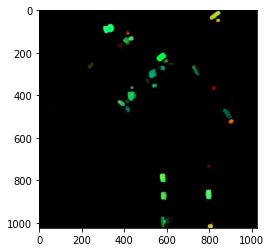

In [71]:
img = mpimg.imread('/content/drive/MyDrive/capstone/data/test/predict/pred-unet_cls/hurricane-florence_00000113_pre_disaster_part2.png')
plt.imshow(img);